# Import Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
#import mapbox_vector_tile
from time import time
import operator
from collections import Counter
import json
import os
import math
import pickle
import random
from sklearn.utils import resample
from numpy import argmax
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import Dataset

from shapely import geometry 
from PIL import Image, ImageDraw
from simplification.cutil import (
    simplify_coords,
    simplify_coords_idx,
    simplify_coords_vw,
    simplify_coords_vw_idx,
    simplify_coords_vwp,
)

# Define Functions

In [69]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    try:
        conn = sqlite3.connect(db_file)
        print(conn)
    except Error as e:
        print(e)
    
    return conn

def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def ScoreFormula(old_number_of_datapoints, new_number_of_datapoints, processing_time):
    return (1 - (new_number_of_datapoints / old_number_of_datapoints)) * (1 - processing_time)


def ScaleFactor(all_geometries):
    b_list = []
    
    for geometries in all_geometries:
        
        polygon = geometry.Polygon(geometries)
        centroid = np.array(polygon.centroid)
        coordinates = np.vstack(geometries)
        
        b = coordinates - centroid
        b_min = np.min(b)
        b_max = np.max(b)
        b_list.append(b_min)
        b_list.append(b_max)
        
    return np.std(b_list)
    
def Normalize_Geometry(coordinates1, scale_factor):
    polygon = geometry.Polygon(coordinates1)
    centroid = np.array(polygon.centroid)
    coordinates2 = np.vstack(coordinates1)
    
    return (coordinates2 - centroid) / scale_factor

def Add_One_Hot(normalized_geometry):
    normalized_geometry = np.insert(normalized_geometry, 2, 1, axis=1)
    normalized_geometry = np.insert(normalized_geometry, 3, 0, axis=1)
    normalized_geometry = np.insert(normalized_geometry, 4, 0, axis=1)
    normalized_geometry[len(normalized_geometry)-1,2] = 0
    normalized_geometry[len(normalized_geometry)-1,4] = 1
    
    return normalized_geometry

def Add_Zero_Padding(one_hotted_geometry, max_length):
    boundary = max_length - len(one_hotted_geometry)
    zero_matrix = np.zeros([boundary,5])
    return np.append(one_hotted_geometry, zero_matrix, axis=0)

def CreateGrid(poly, dx, dy):
    
    x_ls = []
    y_ls = []

    for a in poly:
        x_ls.append(a[0])
    for a in poly:
        y_ls.append(a[1])
        
    minx = min(x_ls)
    maxx = max(x_ls)
    miny = min(y_ls)
    maxy = max(y_ls)

    nx = int(math.ceil(abs(maxx - minx)/dx))
    ny = int(math.ceil(abs(maxy - miny)/dy))

    grid = []       
    for i in range(ny):   
        grid.append(geometry.LineString([[minx,max(maxy-dy*i,miny)], [maxx, max(maxy-dy*i,miny)]]))

    for j in range(nx):
        grid.append(geometry.LineString([[min(minx+dx*j,maxx), maxy], [min(minx+dx*j,maxx), miny]]))
    
    return grid
    
def CheckSameIntersections(poly, simplified_coords, grid, ROUNDING):
    
    original = geometry.Polygon(poly)
    simplified = geometry.Polygon(simplified_coords)

    o_ls = []
    s_ls = []
    for line in grid:
        x = original.intersection(line)
        y = simplified.intersection(line)
        if x:
            if x.geom_type == 'Point':
                o_ls.append(hash(tuple([round(x.coords[0][0],ROUNDING), round(x.coords[0][1],ROUNDING)])))
            if x.geom_type == 'LineString':
                for xy in x.coords:
                    o_ls.append(hash(tuple([round(xy[0],ROUNDING), round(xy[1],ROUNDING)])))
    
        if y:
            if y.geom_type == 'Point':
                s_ls.append(hash(tuple([round(y.coords[0][0],ROUNDING), round(y.coords[0][1],ROUNDING)])))
            if y.geom_type == 'LineString':
                for xy in y.coords:
                    s_ls.append(hash(tuple([round(xy[0],ROUNDING), round(xy[1],ROUNDING)])))
        
    return len(list(set(o_ls).intersection(s_ls))) / len(set(o_ls))

    
def alter_by_zoom(poly, zoom):

    mpp = {
    '0' : 156543,
    '1' : 78271.5,
    '2' : 39135.8,
    '3' : 19567.88,
    '4' : 9783.94,
    '5' : 4891.97,
    '6' : 2445.98,
    '7' : 1222.99,
    '8' : 611.5,
    '9' : 305.75,
    '10' : 152.87,
    '11' : 76.44,
    '12' : 38.219,
    '13' : 19.109,
    '14' : 9.555,
    '15' : 4.777,
    '16' : 2.3887,
    '17' : 1.1943,
    '18' : 0.5972,
    '19' : 0.2986,
    '20' : 0.14929,
    '21' : 0.074646,
    '22' : 0.037323
    }
    return (np.array(poly) / mpp[str(zoom)]).tolist()


def check_pixel_similarity(original_coords, simplified_coords, zoom):
    
    poly1 = alter_by_zoom(original_coords, zoom)
    poly2 = alter_by_zoom(simplified_coords, zoom)

    x = []
    y = []
    for a in poly1:
        x.append(a[0])
        y.append(a[1])
    
    for a in poly1:
        a[0] = a[0] - min(x)
        a[1] = a[1] - min(y)
    
    for a in poly2:
        a[0] = a[0] - min(x)
        a[1] = a[1] - min(y)
    
    width = int(max(x) - min(x))
    height = int(max(y) - min(y))

    poly1 = [tuple(x) for x in poly1]
    poly2 = [tuple(x) for x in poly2]

    img1 = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img1).polygon(poly1, outline=1, fill=0)
    mask1 = np.array(img1)
    
    img2 = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img2).polygon(poly2, outline=1, fill=0)
    mask2 = np.array(img2)
    
    #return np.sum(mask1 == mask2) / (width*height)
    return mask1

#print(check_pixel_similarity(Polygons[0], Polygons[0], 15))



# Load Data

In [59]:
path = '/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/Sample_data_03_05/'
Polygons = []
Types = []

for filename in os.listdir(path):
    if "geometrie." in filename:
        print(filename)
        
        f = open(str(path + filename))
        jsondata = json.load(f)
        
        

        for a in jsondata['features']:
            if len(a['geometry']['coordinates']) == 1:
                Polygons.append(a['geometry']['coordinates'][0])
                Types.append(a['geometry']['type'])
            if a['geometry']['type'] == 'LineString':
                Polygons.append(a['geometry']['coordinates'])
                Types.append(a['geometry']['type'])
            else:
                for b in a['geometry']['coordinates']:
                    Polygons.append(b)
                    Types.append(a['geometry']['type'])
            
geometry_df = pd.DataFrame({'geometry':Polygons,
                            'type':Types})
    
    
    

#f = open('/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/Sample_data_03_05/spoor_export_buitengebied_geometrie.json')
#wegdeeljson = json.load(f)
#wegdeeljson




waterdeel_export_stedelijk_geometrie.json
wegdeel_export_buitengebied_geometrie.json
bag_pand_buitengebeid_export_geometrie.json
wegdeel_export_stedelijk_geometrie.json
spoor_export_stedelijk_geometrie.json
waterdeel_export_buitengebied_geometrie.json
bag_pand_stedelijk_export_geometrie.json
spoor_export_buitengebied_geometrie.json


# Parameters

In [60]:
# Simplification Possibilities
simplify_possibilities = [['D-P', 0], ['D-P', 0.5], ['D-P', 0.1], ['D-P', 0.05], ['D-P', 0.01], ['D-P', 0.005], 
                          ['D-P', 0.001], ['V-W', 0.5], ['V-W', 0.1], ['V-W', 0.05], ['V-W', 0.01], 
                          ['V-W', 0.005]]

#simplify_possibilities = [['D-P', 0], ['D-P', 0.5], ['D-P', 0.1], ['D-P', 0.05], ['D-P', 0.01], ['D-P', 0.005], 
#                          ['D-P', 0.001], ['V-W', 0.5], ['V-W', 0.1], ['V-W', 0.05], ['V-W', 0.01], 
#                          ['V-W', 0.005], ['V-W', 0.001], ['V-W', 0.0005], ['V-W', 0.0001], ['V-W', 0.00005]]

# Polygon length evaluation
MAX_LENGTH_DEFICIT = -0.1

# Grid
dx = 1
dy = 1
ROUNDING = 1

MIN_INTERSECTIONS_PERC = 0.75

# Pre Processing

In [61]:
Polygons = list(geometry_df['geometry'][geometry_df['type'] == 'Polygon'])
Lines = list(geometry_df['geometry'][geometry_df['type'] == 'LineString'])

Polygons_list = []
for element in Polygons:
    if len(element) < 100:
        Polygons_list.append(element)
Polygons = Polygons_list
len(Polygons)
#len(Lines)

294580

In [84]:
results_list = []
length_list = []
Polygons_sample = random.sample(Polygons, 250000)
scale_factor = ScaleFactor(Polygons_sample)
print("Scale Factor done")


# Decide order from longest polygon to smallest polygon
for row in Polygons_sample:

    length_list.append([row, len(row)])

length_list.sort(key=operator.itemgetter(1), reverse=True)
print("Sorted the Polygons")
a=0
for element in length_list:
    print(str(a) + " / " + str(len(length_list)), end="\r")
    a = a + 1
    results_dict = {}
    poly1 = geometry.Polygon(element[0])
    results = []
    #grid = CreateGrid(element[0], dx, dy)
    
    for possibility in simplify_possibilities:
        

        if possibility[0] == 'D-P':
            # Simplification function Douglas-Peucker
            time_start = time()
            simplified_coordinates = simplify_coords(element[0], possibility[1])
            time_end = time()
            process_time = time_end - time_start

        if possibility[0] == 'V-W':
            # Simplification function Visvalingam-Whyatt
            time_start = time()
            simplified_coordinates = simplify_coords_vw(element[0], possibility[1])
            time_end = time()
            process_time = time_end - time_start
        
        
        if len(simplified_coordinates) >= 3:
            poly2 = geometry.Polygon(simplified_coordinates)
            #length_deficit = (poly2.length - poly1.length) / poly1.length
        
            # If the length deficit of the polygon is smaller(greater) than the provided MAX_LENGTH_DEFICIT, 
            # the score gets saved
            #if length_deficit > MAX_LENGTH_DEFICIT:
            
            #if length_deficit == 0:
            #    score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
            #    results.append(score)
            #    continue
                
            #try:
            #    if CheckSameIntersections(element[0], simplified_coordinates, grid, ROUNDING) > MIN_INTERSECTIONS_PERC:
            #        score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
            #        results.append(score)
            #except Exception:
            #    continue
            
            if np.isnan(check_pixel_similarity(element[0], simplified_coordinates, 17)) == True:
                results.append('Remove')
                break
                
                
            if check_pixel_similarity(element[0], simplified_coordinates, 17) == 1:
                score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
                results.append(score)
                
    
    results_dict['polygon'] = Add_Zero_Padding(Add_One_Hot(Normalize_Geometry(element[0], scale_factor)), len(length_list[0][0]))
    if results[0] == 'Remove':
        results_dict['algorithm'] = len(simplify_possibilities)
        
    else:    
        results_dict['algorithm'] = results.index(max(results))
        
    results_list.append(results_dict)

Scale Factor done
Sorted the Polygons


/opt/anaconda3/envs/infoviz/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/opt/anaconda3/envs/infoviz/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in long_scalars


# Save Results

In [85]:
# Saving Labels and Normalized Data
pickle.dump( results_list, open( "/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Scripts/data/temp/results_list.p", "wb" ) )

# Data Balancing

In [4]:
results_list = pickle.load( open( "/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Scripts/data/temp/results_list.p", "rb" ) )

results_df = pd.DataFrame(results_list)

df_majority = results_df[results_df.algorithm == 0]
df_minority = results_df[results_df.algorithm != 0]

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=5000,
                                  random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_majority = df_downsampled[df_downsampled.algorithm == 1]
df_minority = df_downsampled[df_downsampled.algorithm != 1]

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=5000,
                                  random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_majority = df_downsampled[df_downsampled.algorithm == 2]
df_minority = df_downsampled[df_downsampled.algorithm != 2]

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=5000,
                                  random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_majority = df_downsampled[df_downsampled.algorithm == 4]
df_minority = df_downsampled[df_downsampled.algorithm != 4]

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=5000,
                                  random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

df_majority = df_downsampled[df_downsampled.algorithm == 6]
df_minority = df_downsampled[df_downsampled.algorithm != 6]

df_majority_downsampled = resample(df_majority,
                                  replace=False,
                                  n_samples=5000,
                                  random_state=123)

df_downsampled = pd.concat([df_majority_downsampled, df_minority])

results_list = df_downsampled.to_dict('records')


X = []
y = []
a = 0
for element in results_list:
    
    X.append(element['polygon'])
    y.append(element['algorithm'])
X = np.array(X)
y = np.array(y)
y_onehot = to_categorical(y)

# Data Stats

In [5]:
pd.DataFrame({'keys':list(Counter(y).keys()),
              'freq':list(Counter(y).values())})

,keys,freq
0,6,5000
1,4,5000
2,2,5000
3,1,5000
4,0,5000
5,3,5898
6,5,8208
7,7,7306
8,9,2214
9,10,1668


In [ ]:
# Select index of simplification possibility
INDEX = 6


possibility = simplify_possibilities[INDEX]

if possibility[0] == 'D-P':
    # Simplification function Douglas-Peucker
    simplified_coordinates = simplify_coords(coordinates, possibility[1])

if possibility[0] == 'V-W':
    # Simplification function Visvalingam-Whyatt
    simplified_coordinates = simplify_coords_vw(coordinates, possibility[1])

old_xs, old_ys = zip(*coordinates)
new_xs, new_ys = zip(*simplified_coordinates)

print(len(simplified_coordinates))
print(len(coordinates))

# Keras

In [48]:
input_shape = X[0].shape
print(input_shape)
print(len(y_onehot[0]))
model = Sequential()

model.add(layers.Conv1D(filters=32, kernel_size=(5,), activation='relu', padding='SAME', input_shape=input_shape))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(filters=64, kernel_size=(5,), activation='relu', padding='SAME', strides=2))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(y_onehot[0]), activation='softmax'))

model.summary()

(99, 5)
13
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 99, 32)            832       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 33, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17, 64)            10304     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 13)    

In [49]:
model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=0.001), metrics=['accuracy'])

BATCH_SIZE = 99
EPOCHS = 5

history = model.fit(X,
                    y_onehot,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)

Train on 44533 samples, validate on 11134 samples
Epoch 1/5
12375/44533 [=======>......................] - ETA: 23s - loss: 2.3523 - accuracy: 0.1299

KeyboardInterrupt: 

In [6]:
results_tensor = []
for a in results_list:
    x_tensor = np.asarray(a['polygon'])
    y_tensor = np.asarray(int(a['algorithm']))
    results_tensor.append([x_tensor, y_tensor])

In [10]:
for x, y in results_tensor:
    #print(x)
    break

# PyTorch

In [39]:
class MNIST_Polygon(Dataset):
    
    def __init__(self, tensor, transform=None):
        data = [x for x, y in tensor]
        data = np.asarray(data)
        self.data = torch.from_numpy(data).float()
        self.targets = [torch.tensor(y).long() for x, y in tensor]
                
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)
    
MNIST_Polygon(results_tensor).data.shape
X.shape[1]

99

In [53]:
batch_size = X.shape[1]
test_batch_size = X.shape[1]
epochs = 14
lr = 0.001
gamma = 0.7
log_interval = 10
dry_run = False
save_model = False


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(batch_size, 32, 5),
            #nn.BatchNorm1d(32),
            nn.ReLU(),
            #nn.Conv1d(32, 64, 5),
            #nn.BatchNorm1d(64),
            #nn.ReLU(),
            #nn.MaxPool1d(2),
            nn.Dropout(0.25)
        )
        
        self.linear = nn.Sequential(
            nn.Linear(32, len(y_onehot[0])),
            #nn.ReLU(),
            #nn.Dropout(0.5),
            #nn.Linear(64, len(y))
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.linear(x)

In [54]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end="\r")
            if dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [55]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')

    device = "cpu"

    train_kwargs = {'batch_size': batch_size}
    test_kwargs = {'batch_size': test_batch_size}

    transform=transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = MNIST_Polygon(results_tensor, transform=transform)
    dataset2 = MNIST_Polygon(results_tensor, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        
main()

Train Epoch: 1 [55440/55667 (99%)]	Loss: 3.587034
Test set: Average loss: 16.6669, Accuracy: 7180/55667 (12.9%)

Train Epoch: 2 [55440/55667 (99%)]	Loss: 3.436302
Test set: Average loss: 30.3828, Accuracy: 6333/55667 (11.4%)

Train Epoch: 3 [55440/55667 (99%)]	Loss: 3.400969
Test set: Average loss: 35.3026, Accuracy: 6969/55667 (12.5%)

Train Epoch: 4 [55440/55667 (99%)]	Loss: 3.293349
Test set: Average loss: 46.2801, Accuracy: 6822/55667 (12.3%)

Train Epoch: 5 [55440/55667 (99%)]	Loss: 3.227928
Test set: Average loss: 57.2042, Accuracy: 6349/55667 (11.4%)

Train Epoch: 6 [55440/55667 (99%)]	Loss: 3.183948
Test set: Average loss: 63.1023, Accuracy: 6276/55667 (11.3%)

Train Epoch: 7 [55440/55667 (99%)]	Loss: 3.138620
Test set: Average loss: 67.6833, Accuracy: 6475/55667 (11.6%)

Train Epoch: 8 [55440/55667 (99%)]	Loss: 3.165442
Test set: Average loss: 71.0949, Accuracy: 6637/55667 (11.9%)



KeyboardInterrupt: 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(len(X), 32, 5)
        self.pool1 = nn.MaxPool1d(3, 3)
        self.conv2 = nn.Conv1d(61, 64, 5)
        self.pool2 = nn.AvgPool1d(64)
        self.fc1 = nn.Linear(13,13)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.softmax(self.fc1(x))
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Experiments & Code that doesn't get used

In [ ]:
conn_pand_centrum = create_connection("/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/SQLite/Pand_26116_centrum.db")

cur = conn_pand_centrum.cursor()
cur.execute("SELECT data FROM tiles;")

rows = cur.fetchall()
pand_centrum_data = []
for row in rows:
    pand_centrum_data.append(mapbox_vector_tile.decode(row[0]))
    #print(row[0])
print(len(pand_centrum_data))

## Wegdeel Buiten

conn_wegdeel_buiten = create_connection("/Users/davemeijdam/Documents/Data Science/Master/Master Thesis/Data/SQLite/Wegdeel_23770_buitengebied.db")

cur = conn_wegdeel_buiten.cursor()
cur.execute("SELECT data FROM tiles;")

rows = cur.fetchall()
wegdeel_buiten_data = []
for row in rows:
    wegdeel_buiten_data.append(mapbox_vector_tile.decode(row[0]))


Lines = []
Polygons = []
MultiPolygons = []
a=0
for row in pand_centrum_data[:10000]:
    print(str(a) + " / " + str(len(pand_centrum_data)), end="\r")
    a = a + 1
    keys = row.keys()
    
    for key in keys:
        for element in row[key]['features']:
            
            if element['geometry']['type'] == 'LineString': 
                Lines.append(element['geometry']['coordinates'])
            
            if element['geometry']['type'] == 'Polygon':
                Polygons.append(element['geometry']['coordinates'][0])
                
            #if element['geometry']['type'] == 'MultiPolygon':
                #MultiPolygons.append(element['geometry']['coordinates'])
    
    

#test = lvl10_data[0]['spoor.se_fld12_lijngeometrie2d']['features'][0]['geometry']['coordinates']
#print(Polygons)

In [ ]:
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt

ls = []
#for a in wegdeeljson['features'][:5]:
#    ls.append(geometry.Polygon(a['geometry']['coordinates'][0]))

new_shape = so.cascaded_union(ls)
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for geom in new_shape.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=1, fc='r', ec='none')

plt.show()

In [ ]:
import shapely.geometry as sg
import shapely.ops as so
import matplotlib.pyplot as plt


ls = []
for element in wegdeel_buiten_data[3]['wegdeel.se_fld15_vlakgeometrie2d']['features']:
    
    #print(element['geometry']['coordinates'][0])
    #geometry.Polygon(element['geometry']['coordinates'][0])
    element2 = element['geometry']
    
    if element2['type'] == 'MultiPolygon':
        if element2['coordinates']:
            for poly in element2['coordinates'][0]:
                print(poly)
                ls.append(geometry.Polygon(poly))
    
    else:
        ls.append(geometry.Polygon(element['geometry']['coordinates'][0]))

#r1 = sg.Polygon([[243, 2760], [242, 2760], [242, 2761], [243, 2760]])
#r2 = sg.Polygon([[243, 2759], [243, 2760], [244, 2760], [244, 2759], [243, 2759]])
#r3 = sg.Polygon([[244, 2759], [243, 2759], [243, 2760], [244, 2760], [244, 2759]])
#r4 = sg.Polygon([[243, 2759], [242, 2759], [242, 2760], [243, 2760], [243, 2759]])
#r5 = sg.Polygon([[241, 2759], [241, 2760], [242, 2759], [241, 2759]])

new_shape = so.cascaded_union(ls)
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for geom in new_shape.geoms:    
    xs, ys = geom.exterior.xy    
    axs.fill(xs, ys, alpha=1, fc='r', ec='none')

plt.show()

In [ ]:
Lines = []
Polygons = []
MultiPolygons = []
a=0
for row in wegdeel_buiten_data:
    print(str(a) + " / " + str(len(wegdeel_buiten_data)), end="\r")
    a = a + 1
    keys = row.keys()
    
    for key in keys:
        for element in row[key]['features']:
            
            if element['geometry']['type'] == 'LineString': 
                Lines.append(element['geometry']['coordinates'])
            
            if element['geometry']['type'] == 'Polygon':
                Polygons.append(element['geometry']['coordinates'][0])
                
            if element['geometry']['type'] == 'MultiPolygon':
                if element['geometry']['coordinates']:
                    for poly in element['geometry']['coordinates'][0]:
                        MultiPolygons.append(poly)
    
    

#test = lvl10_data[0]['spoor.se_fld12_lijngeometrie2d']['features'][0]['geometry']['coordinates']
#print(Polygons)

#print(len(Lines))
print(len(Polygons))
#print(len(MultiPolygons))

ls = []
for a in Polygons:
    ls.append(len(a))
    
pd.DataFrame({'lengths':Counter(ls).keys(),
              'freq':Counter(ls).values()})

In [62]:
results_list = []
a=0

for element in Polygons[:100]:
    results_dict = {}
    poly1 = geometry.Polygon(element)
    results = []
    
    for possibility in simplify_possibilities:
        
        if possibility[0] == 'D-P':
            # Simplification function Douglas-Peucker
            time_start = time()
            simplified_coordinates = simplify_coords(element, possibility[1])
            time_end = time()
            process_time = time_end - time_start

        if possibility[0] == 'V-W':
            # Simplification function Visvalingam-Whyatt
            time_start = time()
            simplified_coordinates = simplify_coords_vw(element, possibility[1])
            time_end = time()
            process_time = time_end - time_start
        
        
        if len(simplified_coordinates) >= 3:
            poly2 = geometry.Polygon(simplified_coordinates)
            #length_deficit = (poly2.length - poly1.length) / poly1.length
        
            # If the length deficit of the polygon is smaller(greater) than the provided MAX_LENGTH_DEFICIT, 
            # the score gets saved
            #if length_deficit > MAX_LENGTH_DEFICIT:
            
            #if length_deficit == 0:
            #    score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
            #    results.append(score)
            #    continue
                
            #try:
            #    if CheckSameIntersections(element[0], simplified_coordinates, grid, ROUNDING) > MIN_INTERSECTIONS_PERC:
            #        score = ScoreFormula(len(element[0]), len(simplified_coordinates), process_time)
            #        results.append(score)
            #except Exception:
            #    continue
            
            if np.isnan(check_pixel_similarity(element, simplified_coordinates, 17)) == True:
                results.append('Remove')
                break
                
                
            if check_pixel_similarity(element, simplified_coordinates, 17) == 1:
                score = ScoreFormula(len(element), len(simplified_coordinates), process_time)
                results.append(score)
        
    results_dict['index'] = a
    results_dict['algorithm'] = results.index(max(results))
    results_list.append(results_dict)
    a = a + 1
    
results_list 

[{'index': 0, 'algorithm': 0},
 {'index': 1, 'algorithm': 0},
 {'index': 2, 'algorithm': 0},
 {'index': 3, 'algorithm': 0},
 {'index': 4, 'algorithm': 0},
 {'index': 5, 'algorithm': 0},
 {'index': 6, 'algorithm': 0},
 {'index': 7, 'algorithm': 0},
 {'index': 8, 'algorithm': 1},
 {'index': 9, 'algorithm': 1},
 {'index': 10, 'algorithm': 5},
 {'index': 11, 'algorithm': 2},
 {'index': 12, 'algorithm': 4},
 {'index': 13, 'algorithm': 4},
 {'index': 14, 'algorithm': 4},
 {'index': 15, 'algorithm': 4},
 {'index': 16, 'algorithm': 0},
 {'index': 17, 'algorithm': 0},
 {'index': 18, 'algorithm': 0},
 {'index': 19, 'algorithm': 0},
 {'index': 20, 'algorithm': 0},
 {'index': 21, 'algorithm': 0},
 {'index': 22, 'algorithm': 5},
 {'index': 23, 'algorithm': 1},
 {'index': 24, 'algorithm': 6},
 {'index': 25, 'algorithm': 6},
 {'index': 26, 'algorithm': 0},
 {'index': 27, 'algorithm': 0},
 {'index': 28, 'algorithm': 0},
 {'index': 29, 'algorithm': 0},
 {'index': 30, 'algorithm': 0},
 {'index': 31, 'al

['D-P', 0.5]
17 / 25


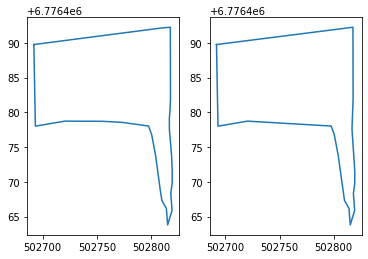

In [68]:
RESULTS_INDEX = 23

algorithm = simplify_possibilities[results_list[RESULTS_INDEX]['algorithm']]
print(algorithm)
points = len(Polygons[results_list[RESULTS_INDEX]['index']])
o_xs, o_ys = zip(*Polygons[results_list[RESULTS_INDEX]['index']])
#geometry.Polygon(Polygons[results_list[RESULTS_INDEX]['index']])

if algorithm[0] == 'D-P':
    simplified_poly = geometry.Polygon(simplify_coords(Polygons[results_list[RESULTS_INDEX]['index']], algorithm[1]))
    simplified_points = len(simplify_coords(Polygons[results_list[RESULTS_INDEX]['index']], algorithm[1]))
    s_xs, s_ys = zip(*simplify_coords(Polygons[results_list[RESULTS_INDEX]['index']], algorithm[1]))
    
if algorithm[0] == 'V-W':
    simplified_poly = geometry.Polygon(simplify_coords_vw(Polygons[results_list[RESULTS_INDEX]['index']], algorithm[1]))
    simplified_points = len(simplify_coords_vw(Polygons[results_list[RESULTS_INDEX]['index']], algorithm[1]))
    s_xs, s_ys = zip(*simplify_coords_vw(Polygons[results_list[RESULTS_INDEX]['index']], algorithm[1]))

print(str(simplified_points) + " / " + str(points))
geometry.Polygon(Polygons[results_list[RESULTS_INDEX]['index']])
simplified_poly    

plt.subplot(1, 2, 1)
plt.plot(o_xs,o_ys)

plt.subplot(1, 2, 2)
plt.plot(s_xs,s_ys)

plt.show()

In [44]:
a = MNIST_Polygon(results_tensor).data 
m = nn.Conv1d(99, 32, 5) 
out = m(a)
print(a.shape)
print(out.size())
print(m)

torch.Size([55667, 99, 5])
torch.Size([55667, 32, 1])
Conv1d(99, 32, kernel_size=(5,), stride=(1,))


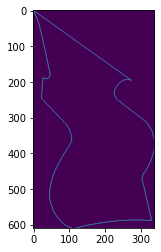

In [94]:
plt.imshow(check_pixel_similarity(Polygons[4], Polygons[0], 20))